## Neural Style Transfer 
## DD2424 Project based on : 'A Neural Algorithm of Artistic Style' Leon A. Gatys,Alexander S. Ecker,Matthias Bethge


### Import packages and libraries

In [162]:
import os 
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

## Functions

In [163]:
#Load images and preprocess them to the correct shape
def loadImg(path): 
  x = load_img(path, target_size= (224, 224))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  preprocess_input(x)

  x = (x + 127.5)/255
  
  return x

def imShow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  
  if title:
    plt.title(title)

def vgg_model(layers): 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(F):
  G = np.matmul(np.transpose(F), F)
  return G

def compute_loss(noise_style_features,noise_content_features,style_features,content_features):
  alpha_beta_ratio = 1e-3
  beta = 1

  G = []
  A = []
  E = []
  L_style = 0
  #Compute Gram matrices and loss for style
  for layer in range(len(noise_style_features)):
      Ml = noise_style_features[layer].shape[1]*noise_style_features[layer].shape[2]
      Nl = noise_style_features[layer].shape[3]

      Fl = np.reshape(noise_style_features[layer],(Ml, Nl))
      G.append(gram_matrix(Fl))

      Al = np.reshape(style_features[layer],(Ml, Nl))
      A.append(gram_matrix(Al))

      E.append(np.sum((G[layer] - A[layer])**2)/(4 * (Nl**2) * (Ml**2)))
      
      L_style += E[layer]/len(noise_style_features)


  # Compute loss for content
  length = noise_content_features.shape[1] * noise_content_features.shape[2]
  width = noise_content_features.shape[3]
  L_content = 0.5*np.sum((noise_content_features.reshape((length,width)) - content_features.reshape((length,width)))**2)

  return beta*(alpha_beta_ratio*L_content + L_style)


## Prepare the model VGG19

In [164]:
#Following the method of the paper : we first import the VGG19-Network. The
#feature space provided by the 16 convolutional and 5 pooling layers of the 19 #layer VGGNetwork

VGG19 = tf.keras.applications.VGG19(include_top=False)

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Extract features from content and style image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


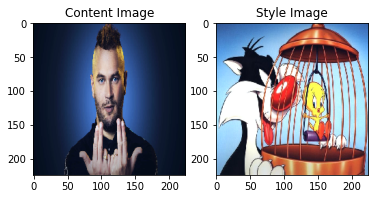

In [165]:
#Get the path of the pictures we want
content_path = tf.keras.utils.get_file('jul.jpg', 'https://img.lemde.fr/2020/11/18/494/0/8688/4340/1440/720/60/0/7d2c869_856070765-jul-fifou-0888.jpg')
style_path = tf.keras.utils.get_file('titiandgros.jpg', 'https://i.pinimg.com/564x/99/d3/21/99d321028e0803f9c928aadc78f934f8.jpg')

#Load them
content_img = loadImg(content_path)
style_img = loadImg(style_path)

plt.subplot(1,2,1)
imShow(content_img, 'Content Image')
plt.subplot(1,2,2)
imShow(style_img, 'Style Image')

content_model = vgg_model(content_layers)
style_model = vgg_model(style_layers)

#Create the features map of both images
content_features = content_model.predict(content_img)
style_features = style_model.predict(style_img)

#Print shapes to debug
print ("Content features Size : ")
print(content_features.shape)
print('Style features Size : ')
for i in range(len(style_features)):
    print(style_features[i].shape)

## Extract features from the white noise image

'\nContent features Size : \n(1, 14, 14, 512)\nStyle features Size : \n(1, 224, 224, 64)\n(1, 112, 112, 128)\n(1, 56, 56, 256)\n(1, 28, 28, 512)\n(1, 14, 14, 512)\n\n'

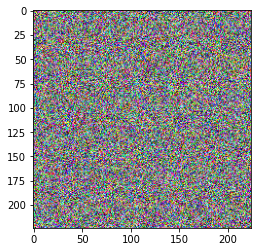

In [166]:
noisy_image = np.random.uniform(0, 1, [1, 224, 224, 3])
imShow(noisy_image)

#Create the features map of both images
noise_content_features = content_model.predict(noisy_image)
noise_style_features = style_model.predict(noisy_image)
'''
Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)

'''


In [212]:
style_targets = A
content_targets = noise_content_features.reshape((length,width))

# TF Optimizers

tf_noise_image = tf.Variable(noisy_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1 = 0.99, epsilon = 1e-1)

# a = compute_loss(noise_style_features,noise_content_features,style_features,content_features)

# @tf.function()
def train_step(image,noise_style_features, noise_content_features, style_features,content_features):
  with tf.GradientTape() as tape:
    loss = style_content_loss(noise_style_features, noise_content_features, style_features, content_features)



  print(loss)
  print(image)
  grad = tape.gradient(loss, image)
  print(grad)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


<tf.Variable 'Variable:0' shape=(1, 224, 224, 3) dtype=float64, numpy=
array([[[[0.68592762, 0.88927176, 0.49278343],
         [0.69638467, 0.17534101, 0.69651564],
         [0.56913041, 0.30906454, 0.42121854],
         ...,
         [0.8993702 , 0.4826465 , 0.03762869],
         [0.01054894, 0.31819102, 0.62315687],
         [0.62675323, 0.94042453, 0.16856163]],

        [[0.00663991, 0.84622172, 0.50122118],
         [0.66636917, 0.18687926, 0.44447981],
         [0.88300949, 0.64265901, 0.36751878],
         ...,
         [0.62942471, 0.04393338, 0.11092625],
         [0.82232276, 0.5304711 , 0.21011996],
         [0.84136588, 0.05724862, 0.45826484]],

        [[0.64174773, 0.34951323, 0.53495694],
         [0.2111266 , 0.89278653, 0.47746711],
         [0.39478507, 0.98117334, 0.20202176],
         ...,
         [0.60972232, 0.31260963, 0.60696288],
         [0.97799575, 0.78961571, 0.27950192],
         [0.2688371 , 0.93061395, 0.69927644]],

        ...,

        [[0.6648773 ,

In [210]:
def style_content_loss(noise_style_features, noise_content_features, style_features, content_features):
    beta=1e-2
    alpha=1e4

    style_tensor_list = []
    for i in range(len(noise_style_features)):
        a = np.mean((noise_style_features[i]-style_features[i])**2) 
        style_tensor_list.append(tf.convert_to_tensor(a))

    style_loss = tf.add_n(style_tensor_list)
    style_loss *= beta / len(noise_style_features)

    content_tensor_list = []
    for i in range(len(noise_content_features)):
        a = np.mean((noise_content_features[i]-content_features[i])**2) 
        content_tensor_list.append(tf.convert_to_tensor(a))

    content_loss = tf.add_n(content_tensor_list)
    content_loss *= beta / len(noise_content_features)

    loss = style_loss + content_loss
    return loss

In [211]:
train_step(tf_noise_image,noise_style_features, noise_content_features, style_features, content_features)


tf.Tensor(0.90888405, shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=(1, 224, 224, 3) dtype=float64, numpy=
array([[[[0.68592762, 0.88927176, 0.49278343],
         [0.69638467, 0.17534101, 0.69651564],
         [0.56913041, 0.30906454, 0.42121854],
         ...,
         [0.8993702 , 0.4826465 , 0.03762869],
         [0.01054894, 0.31819102, 0.62315687],
         [0.62675323, 0.94042453, 0.16856163]],

        [[0.00663991, 0.84622172, 0.50122118],
         [0.66636917, 0.18687926, 0.44447981],
         [0.88300949, 0.64265901, 0.36751878],
         ...,
         [0.62942471, 0.04393338, 0.11092625],
         [0.82232276, 0.5304711 , 0.21011996],
         [0.84136588, 0.05724862, 0.45826484]],

        [[0.64174773, 0.34951323, 0.53495694],
         [0.2111266 , 0.89278653, 0.47746711],
         [0.39478507, 0.98117334, 0.20202176],
         ...,
         [0.60972232, 0.31260963, 0.60696288],
         [0.97799575, 0.78961571, 0.27950192],
         [0.2688371 , 0.93061395, 0.6

ValueError: No gradients provided for any variable: ['Variable:0'].